In [1]:
#two_streamlines.ipynb
#by Joe Hahn,
#jmh.datasciences@gmail.com,
#4 September 2018.
#
#simulate the viscous radial spreading of circular gravitating 2-streamline ringlet

In [2]:
#prep plots
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
sns.set(font_scale=1.5, font='DejaVu Sans')
import numpy as np

In [3]:
#restore output
from helper_fns import *
execfile('inputs.py')
r, t, vr, vt, times, lambda0 = restore_output(output_folder)
a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
print 'r.shape = ', r.shape
print 'total_ring_mass = ', total_ring_mass
print 'shear_viscosity = ', shear_viscosity

r.shape =  (1001, 2, 11)
total_ring_mass =  5e-09
shear_viscosity =  3e-11


In [4]:
#check a,e
print radial_width, total_ring_mass, shear_viscosity
print a.min(), a.max(), e.min(), e.max()

0.001 5e-09 3e-11
0.9931579198424895 1.0079297609290385 9.078949980700912e-09 1.666837180131292e-07


In [5]:
#a_avg = each streamline's longitudinally-average semimajor axis vs times
a_avg = a.mean(axis=2)
print a_avg.shape

(1001, 2)


In [6]:
#compute delta_a=a_outer-a_inner versus time
a_outer = a_avg[:, 1]
a_inner = a_avg[:, 0]
delta_a = a_outer - a_inner

In [7]:
#a_mid = ringlet's mean semimajor axis versus time
a_mid = (a_inner + a_outer)/2
print a_mid.shape

(1001,)


In [8]:
#t_orbits = time in units of ringlet orbit periods
twopi = 2*np.pi
t_orbits = times/twopi

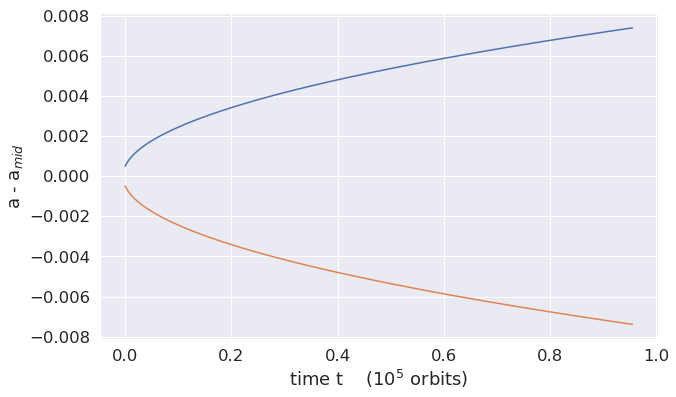

In [9]:
#plot a - a_mid versus time
f, ax = plt.subplots(figsize=(10, 6))
xp = t_orbits/1.0e5
yp = a_outer - a_mid
p = ax.plot(xp, yp, linestyle='-')
yp = a_inner - a_mid
p = ax.plot(xp, yp, linestyle='-')
p = ax.set_xlabel(r'time t    ($10^5$ orbits)')
p = ax.set_ylabel('a - a$_{mid}$')

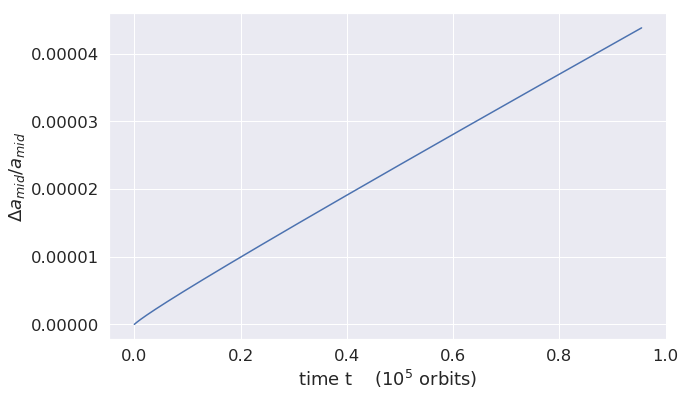

In [10]:
#plot fractional change in a_mid
#note that a_mid moves outwards despite energy loss due to dissipation
f, ax = plt.subplots(figsize=(10, 6))
xp = t_orbits/1.0e5
yp = (a_mid - a_mid[0])/a_mid
p = ax.plot(xp, yp, linestyle='-')
p = ax.set_xlabel(r'time t    ($10^5$ orbits)')
p = ax.set_ylabel('$\Delta a_{mid}/a_{mid}$')

In [11]:
#get each particle's mass
a0 = a[0]
mass = lambda0*(twopi*a0/particles_per_streamline)
print lambda0.shape, mass.shape
print 'mass check = ', mass.sum()/total_ring_mass

(2, 11) (2, 11)
mass check =  1.0000000000067595


In [12]:
##each streamline's mass
#mass_inner = mass[0].sum()
#mass_outer = mass[1].sum()
#print 'mass check = ', (mass_inner + mass_outer)/total_ring_mass

In [13]:
#compute each particle's energy assuming no self gravity or pressure
def system_energy(GM, J2, Rp, mass, r, vr, vt):
    grav_potential = - GM/r - (J2*GM*Rp*Rp/2)/(r**3)
    specific_energy = (vr**2 + vt**2)/2 + grav_potential
    energy = np.zeros_like(specific_energy)
    for idx in range(len(energy)):
        energy[idx] = mass*specific_energy[idx]
    return energy

In [14]:
#system's energy
GM = 1.0
energy = system_energy(GM, J2, Rp, mass, r, vr, vt)
streamline_energy = energy.sum(axis=2)
energy_total = streamline_energy.sum(axis=1)
inner_streamline_energy = streamline_energy[:, 0]
outer_streamline_energy = streamline_energy[:, 1]
total_streamline_energy = inner_streamline_energy + outer_streamline_energy

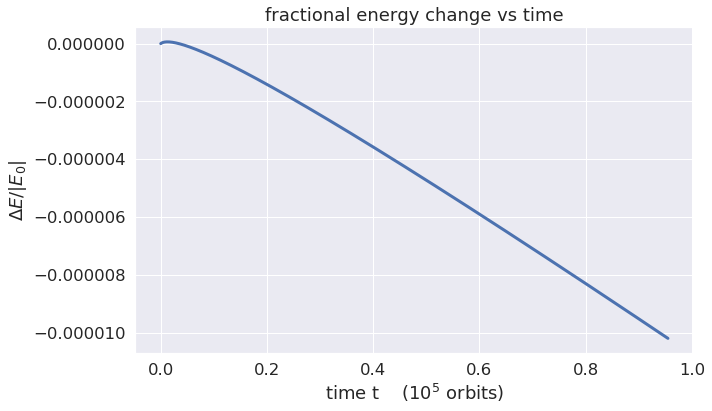

In [15]:
#plot fractional change in total_streamline_energy vs time
f, ax = plt.subplots(figsize=(10, 6))
xp = t_orbits/1.0e5
delta_E = total_streamline_energy - total_streamline_energy[0]
yp = delta_E/np.abs(total_streamline_energy[0])
p = ax.plot(xp, yp, linestyle='-', linewidth=3)
p = ax.set_title('fractional energy change vs time')
p = ax.set_xlabel(r'time t    ($10^5$ orbits)')
p = ax.set_ylabel(r'$\Delta E/|E_0|$')

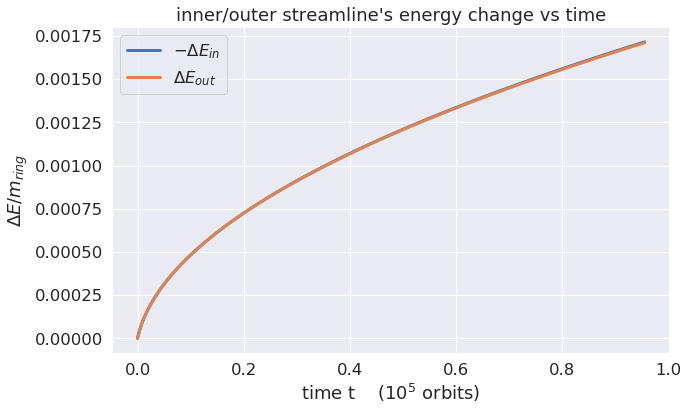

In [16]:
#plot fractional change in energy_total vs time
#look close to see that |Delta-E_in| is slightly larger than |Delta-E_out|
f, ax = plt.subplots(figsize=(10, 6))
xp = t_orbits/1.0e5
factor = total_ring_mass
yp = -(inner_streamline_energy - inner_streamline_energy[0])/factor
p = ax.plot(xp, yp, linestyle='-', linewidth=3, label=r'$-\Delta E_{in}$')
yp = (outer_streamline_energy - outer_streamline_energy[0])/factor
p = ax.plot(xp, yp, linestyle='-', linewidth=3, label=r'$\Delta E_{out}$')
p = ax.set_title("inner/outer streamline's energy change vs time")
p = ax.set_xlabel(r'time t    ($10^5$ orbits)')
p = ax.set_ylabel(r'$\Delta E/m_{ring}$')
p = plt.legend()

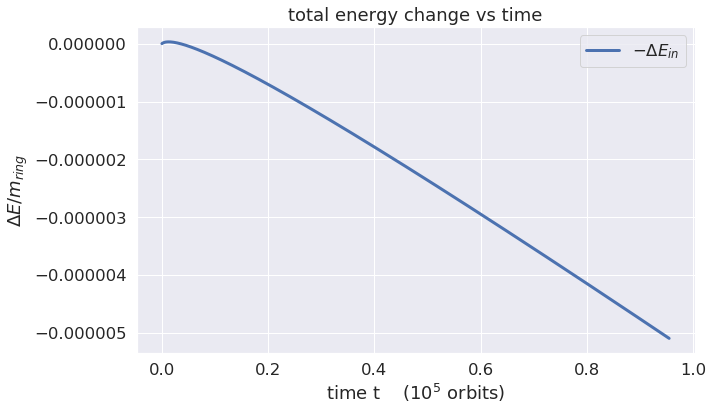

In [17]:
#plot change in total_streamline_energy vs time
f, ax = plt.subplots(figsize=(10, 6))
xp = t_orbits/1.0e5
factor = total_ring_mass
yp = (total_streamline_energy - total_streamline_energy[0])/factor
p = ax.plot(xp, yp, linestyle='-', linewidth=3, label=r'$-\Delta E_{in}$')
p = ax.set_title('total energy change vs time')
p = ax.set_xlabel(r'time t    ($10^5$ orbits)')
p = ax.set_ylabel(r'$\Delta E/m_{ring}$')
p = plt.legend()

In [18]:
#simulation's energy dissipation rate
dt = times[1] - times[0]
dE_dt = np.gradient(total_streamline_energy, dt)

In [19]:
#expected dissipation rate for ring having N>>2 streamlines
Om = Omega(J2, Rp, a_mid)
dE_dt_many = -(9.0/4)*(total_ring_mass*shear_viscosity)*(Om**2) + 0*times

In [20]:
#expected dissipation rate for ring having N=2 streamlines
Om = Omega(J2, Rp, a_mid)
dE_dt_2 = -(3.0/8)*(total_ring_mass*shear_viscosity)*(Om**2) + 0*times

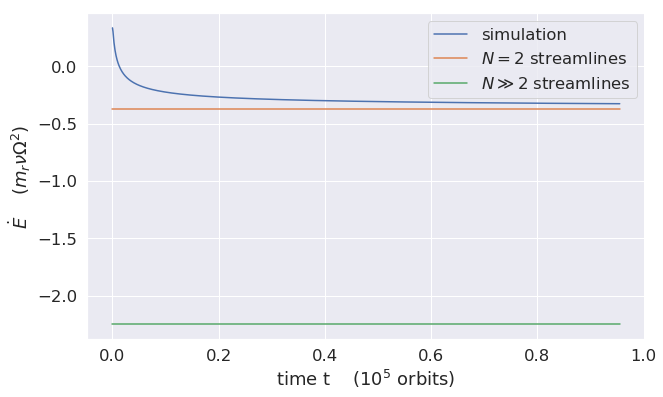

In [21]:
#plot dE/dt over time
f, ax = plt.subplots(figsize=(10, 6))
xp = t_orbits/1.0e5
factor = shear_viscosity*(Om[0]**2)*total_ring_mass
yp = dE_dt/factor
p = ax.plot(xp, yp, linestyle='-', label='simulation')
yp = dE_dt_2/factor
p = ax.plot(xp, yp, linestyle='-', label=r'$N=2$ streamlines')
yp = dE_dt_many/factor
p = ax.plot(xp, yp, linestyle='-', label=r'$N\gg2$ streamlines')
p = ax.set_xlabel(r'time t    ($10^5$ orbits)')
p = ax.set_ylabel(r'$\dot{E}$    $(m_r\nu\Omega^2)$')
p = plt.legend()